### For filtering, spike detection and sorting to obtain single unit activity (discard MUAs)

In [1]:
import pandas as pd
import os
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

#### Filtering

In [77]:
data = pd.read_csv('/Users/jazlynn/Downloads/neurons-csv-format/neuron_180.csv')

In [2]:
# change no need wrapper... use filtfilt

# Apply a bandpass filter to isolate the frequency range of interest
lowcut = 300  # Low cutoff frequency in Hz
highcut = 6000  # High cutoff frequency in Hz
fs = 12500  # Sampling frequency in Hz

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

filtered_data = butter_bandpass_filter(data['Voltage'], lowcut, highcut, fs)
plt.plot(data['Time'], data['Voltage'], label='raw')
plt.plot(data['Time'],filtered_data, label='filtered')
plt.legend()
# plt.xlim(2.85,2.854) # one AP
# plt.xlim(1,1.5)

NameError: name 'data' is not defined

#### find peaks

(13000.0, 15000.0)

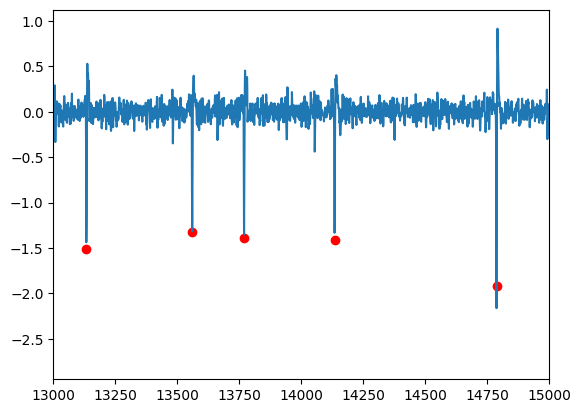

In [81]:
# Find peaks in the filtered data above a certain threshold
threshold = 3.0  # Adjust this threshold as needed
spike_peaks, _ = find_peaks(-filtered_data, height=-np.percentile(filtered_data,0.7))
plt.plot([i for i in range(len(data))],filtered_data, label='filtered')
plt.scatter(spike_peaks,data['Voltage'].iloc[spike_peaks], label = 'spikes', color='red')
plt.xlim(13000,15000)

In [76]:
np.percentile(filtered_data,0.7)

-0.1140628679856861

#### waveforms and clustering

In [29]:
window_size = 50  # Adjust as needed
spike_waveforms = []
for peak in spike_peaks:
    if peak - window_size >= 0 and peak + window_size < len(filtered_data):
        spike_waveforms.append(filtered_data[peak - window_size: peak + window_size])
spike_waveforms = np.array(spike_waveforms)

# Apply PCA for dimensionality reduction
n_components = 3  # Adjust as needed
pca = PCA(n_components=n_components)
waveform_features = pca.fit_transform(spike_waveforms)

# Cluster the waveforms using K-means
n_clusters = 4  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(waveform_features)

/Users/jazlynn/opt/anaconda3/envs/NP/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Viz

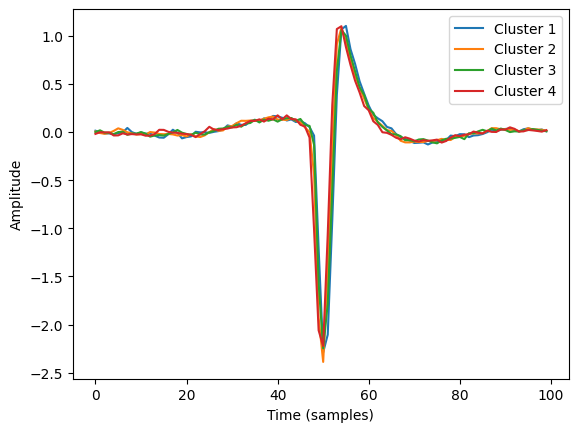

In [31]:
# Visualize the clustered waveforms
for i in range(n_clusters):
    cluster_waveforms = spike_waveforms[cluster_labels == i]
    mean_waveform = np.mean(cluster_waveforms, axis=0)
    plt.plot(mean_waveform, label=f'Cluster {i + 1}')

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#### Process all neurons

In [96]:
lowcut = 300  # Low cutoff frequency in Hz
highcut = 6000  # High cutoff frequency in Hz
fs = 12500  # Sampling frequency in Hz
window_size = 25  # half of what the algorithm looks at when clustering
n_components = 3  # number of PCA components
cluster_numbers = [i for i in range(2,6)]

figure_idx = 0
fig, axes = None, None

for neuron in range(1,360+1):
    file = os.path.join('/Users/jazlynn/Downloads/neurons-csv-format','neuron_' + str(neuron).zfill(3) + '.csv')
    if os.path.exists(file):
        data = pd.read_csv(file)
        filtered_data = butter_bandpass_filter(data['Voltage'], lowcut, highcut, fs)
        spike_peaks, _ = find_peaks(-filtered_data, height=-np.percentile(filtered_data,0.7))
        
        spike_waveforms = []
        for peak in spike_peaks:
            if peak - window_size >= 0 and peak + window_size < len(filtered_data):
                spike_waveforms.append(filtered_data[peak - window_size: peak + window_size])
        spike_waveforms = np.array(spike_waveforms)

        # Apply PCA for dimensionality reduction
        pca = PCA(n_components=n_components)
        waveform_features = pca.fit_transform(spike_waveforms)

        si_score = []
        for n_clusters in cluster_numbers:
            kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
            cluster_labels = kmeans.fit_predict(waveform_features)
            si_score.append(silhouette_score(waveform_features, cluster_labels, metric='euclidean'))
            
        opt_n_clusters = cluster_numbers[np.argmax(si_score)]
        print(opt_n_clusters)
        
        kmeans = KMeans(n_clusters=opt_n_clusters, random_state=0, n_init='auto')
        cluster_labels = kmeans.fit_predict(waveform_features)
        
        # plt.figure()
        # plt.title(file)
        # for i in range(opt_n_clusters):
        #     cluster_waveforms = spike_waveforms[cluster_labels == i]
        #     mean_waveform = np.mean(cluster_waveforms, axis=0)
        #     plt.plot([j/(fs/1000) for j in range(-window_size,window_size)],mean_waveform, label=f'{np.sum(cluster_labels==i)} spikes')
        #     plt.xlabel('Time (ms)')
        #     plt.ylabel('Amplitude')
        #     plt.legend()
            
        if figure_idx % 9 == 0:
            if fig is not None:
                    plt.tight_layout()
                    # Save the figure
                    fig.savefig(os.path.join('Group5_spikesorting_QC', f'figure_{figure_idx//9}.png'))
                    plt.close(fig)
            fig, axes = plt.subplots(3, 3, figsize=(15, 15))
            plt.suptitle(f'Figures {figure_idx//9 + 1}-{figure_idx//9 + 1}')

        i, j = figure_idx % 9 // 3, figure_idx % 9 % 3
        
        for k in range(opt_n_clusters):
            cluster_waveforms = spike_waveforms[cluster_labels == k]
            mean_waveform = np.mean(cluster_waveforms, axis=0)
            axes[i, j].plot([t/(fs/1000) for t in range(-window_size,window_size)],mean_waveform, label=f'{np.sum(cluster_labels==k)} spikes')
        
        axes[i, j].set_title('neuron ' + str(neuron))
        axes[i, j].set_xlabel('Time (ms)')
        axes[i, j].set_ylabel('Amplitude')
        axes[i, j].legend()
        figure_idx += 1

# last fig
if fig is not None:
    plt.tight_layout()
    # Save the last figure
    fig.savefig(os.path.join('Group5_spikesorting_QC', f'figure_{figure_idx//9}.png'))
    plt.close(fig)

2
4
4
2
3
2
3
5
2
4
3
2
3
2
3
2
4
3
2
2
2
5
2
2
3
2
2
2
3
2
2
2
2
4
4
2
3
3
4
4
4
5
2
2
2
2
2
2
2
2
2
4
2
5
4
3
4
2
3
5
5
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
5
2
2
2
4
2
2
2
2
2
2
2
2
2
2
2
2
2
4
2
2
2
2
2
2
2
2
2
3
2
3
2
2
3
4
2
2
3
2
2
2
2
4
2
2
2
3
4
2
3
2
2
2
2
2
2
3
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
4
2
4
2
2
4
2
2
2
2
2
2
2
2
2
3
2
4
2
2
2
2
2
4
3
2
2
3
2
2
2
2
3
2
3
3
2
2
2
2
3
2
4
2
2
2
2
2
2
2
3
2
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
3
2
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
3
2
2
2
2
3
2
2
2
2
2
3
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
5
2
2
2
2
3
2
2
2
2
2
4
2
2
2


#### Extract spike train

In [38]:
a = []
# a.append(1)
if a:
    print('not empty')
else:
    print('empty')

empty


In [83]:
### Process neurons without viz

lowcut = 300  # Low cutoff frequency in Hz
highcut = 6000  # High cutoff frequency in Hz
fs = 12500  # Sampling frequency in Hz
window_size = 25  # half of what the algorithm looks at when clustering
n_components = 3  # number of PCA components
cluster_numbers = [i for i in range(2,6)]

figure_idx = 0
fig, axes = None, None

results_dict = {'neuron_' + str(i) :None for i in range(1,360+1)}
peaks_dict = {'neuron_' + str(i) :None for i in range(1,360+1)}
clusters_dict = {'neuron_' + str(i) :None for i in range(1,360+1)}

for neuron in range(1,360+1):
    file = os.path.join('/Users/jazlynn/Downloads/neurons-csv-format','neuron_' + str(neuron).zfill(3) + '.csv')
    if os.path.exists(file):
        data = pd.read_csv(file)
        filtered_data = butter_bandpass_filter(data['Voltage'], lowcut, highcut, fs)
        spike_peaks, _ = find_peaks(-filtered_data, height=-np.percentile(filtered_data,0.7))
        
        spike_waveforms = []
        edge_peak_list = []
        for n_peak,peak in enumerate(spike_peaks):
            if peak - window_size >= 0 and peak + window_size < len(filtered_data):
                spike_waveforms.append(filtered_data[peak - window_size: peak + window_size])
            else:
                edge_peak_list.append(n_peak)
                
        if edge_peak_list:
            spike_peaks = np.delete(spike_peaks, edge_peak_list)
            # print('edge spikes present')
            
        peaks_dict['neuron_' + str(neuron)] = spike_peaks
        spike_waveforms = np.array(spike_waveforms)

        # Apply PCA for dimensionality reduction
        pca = PCA(n_components=n_components)
        waveform_features = pca.fit_transform(spike_waveforms)

        si_score = []
        for n_clusters in cluster_numbers:
            kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
            cluster_labels = kmeans.fit_predict(waveform_features)
            si_score.append(silhouette_score(waveform_features, cluster_labels, metric='euclidean'))
            
        opt_n_clusters = cluster_numbers[np.argmax(si_score)]
        # print(opt_n_clusters)
        
        kmeans = KMeans(n_clusters=opt_n_clusters, random_state=0, n_init='auto')
        cluster_labels = kmeans.fit_predict(waveform_features)
        clusters_dict['neuron_' + str(neuron)] = cluster_labels
        
        for final_cluster in range(opt_n_clusters):
            refractory_violation_counter = 0
            cluster_spikes = spike_peaks[cluster_labels==final_cluster]
            for isi in [cluster_spikes[i]-cluster_spikes[i-1] for i in range(1,len(cluster_spikes))]:
                if isi <12.5:
                    refractory_violation_counter = refractory_violation_counter + 1
            
            if refractory_violation_counter > 0:        
                print('neuron ' + str(neuron) + ' cluster ' + str(final_cluster) + ' has ' + str(refractory_violation_counter) + ' refractory violations')

neuron 1 cluster 1 has 1 refractory violations
neuron 2 cluster 3 has 3 refractory violations
neuron 4 cluster 0 has 20 refractory violations
neuron 4 cluster 1 has 19 refractory violations
neuron 4 cluster 2 has 16 refractory violations
neuron 4 cluster 3 has 9 refractory violations
neuron 5 cluster 0 has 39 refractory violations
neuron 6 cluster 0 has 1 refractory violations
neuron 6 cluster 1 has 11 refractory violations
neuron 7 cluster 0 has 1 refractory violations
neuron 7 cluster 1 has 4 refractory violations
neuron 8 cluster 0 has 20 refractory violations
neuron 8 cluster 1 has 7 refractory violations
neuron 8 cluster 2 has 22 refractory violations
neuron 9 cluster 0 has 48 refractory violations
neuron 9 cluster 1 has 13 refractory violations
neuron 9 cluster 2 has 12 refractory violations
neuron 9 cluster 3 has 11 refractory violations
neuron 9 cluster 4 has 8 refractory violations
neuron 10 cluster 0 has 3 refractory violations
neuron 11 cluster 0 has 1 refractory violations


/var/folders/hg/11zt_k_x3xl_zyjfsf79w32c0000gn/T/ipykernel_41016/1438202097.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array(test)


Text(0.5, 1.0, 'first 1s of recording, 4 cluster identified')

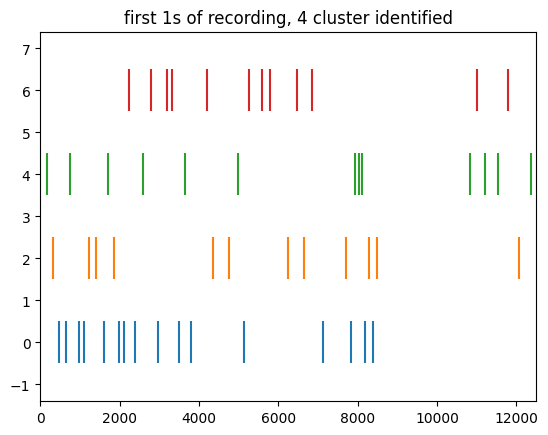

In [97]:
neruon_viz = 357

test = []
test.append(peaks_dict['neuron_' +str(neruon_viz)][clusters_dict['neuron_' +str(neruon_viz)]==0])
test.append(peaks_dict['neuron_' +str(neruon_viz)][clusters_dict['neuron_' +str(neruon_viz)]==1])
test.append(peaks_dict['neuron_' +str(neruon_viz)][clusters_dict['neuron_' +str(neruon_viz)]==2])
test.append(peaks_dict['neuron_' +str(neruon_viz)][clusters_dict['neuron_' +str(neruon_viz)]==3])
test = np.array(test)
plt.eventplot(test, lineoffsets=2, colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
plt.xlim(0, 12500)
plt.title('first 1s of recording, 4 cluster identified')

number of refractory violations:  0


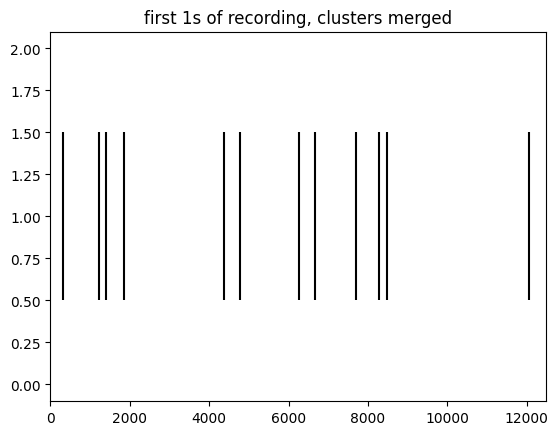

In [101]:
neruon_viz = 357
plt.eventplot(peaks_dict['neuron_' +str(neruon_viz)][clusters_dict['neuron_' +str(neruon_viz)]==1],color='black')
plt.xlim(0, 12500)
plt.title('first 1s of recording, clusters merged')

refractory_violation_counter = 0
for isi in [peaks_dict['neuron_' +str(neruon_viz)][clusters_dict['neuron_' +str(neruon_viz)]==1][i]-peaks_dict['neuron_' +str(neruon_viz)][clusters_dict['neuron_' +str(neruon_viz)]==1][i-1] for i in range(1,len(peaks_dict['neuron_' +str(neruon_viz)][clusters_dict['neuron_' +str(neruon_viz)]==1]))]:
    if isi <12.5:
        refractory_violation_counter = refractory_violation_counter + 1

print('number of refractory violations: ', refractory_violation_counter)

In [57]:
for isi in [spike_peaks[i]-spike_peaks[i-1] for i in range(1,len(spike_peaks))]:
    if isi <12.5:
        print('refract viol')

In [29]:
len(cluster_labels)

1271

In [28]:
len(spike_peaks)

1272

In [31]:
spike_waveforms.shape

(1271, 50)

In [24]:
spike_peaks[cluster_labels==i]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1272 but corresponding boolean dimension is 1271

In [19]:
temp = np.zeros((len(filtered_data)))
temp[spike_peaks[cluster_labels==1]] = 1
np.unique(temp,return_counts=True)

(array([0., 1.]), array([149553,    447]))

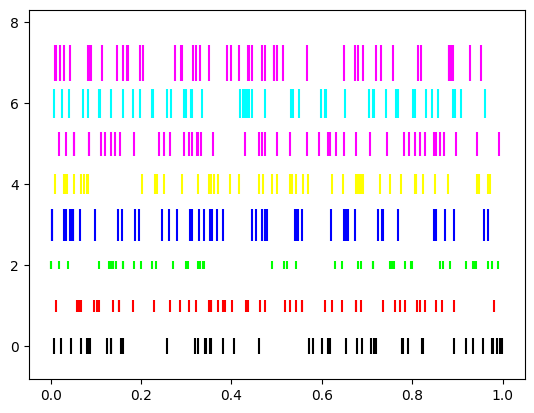

In [44]:


 

# Create rows of random data with 50 data points simulating rows of spike trains

neuralData = np.random.random([8, 50])

 

# Set different colors for each neuron

colorCodes = np.array([[0, 0, 0],

                        [1, 0, 0],

                        [0, 1, 0],

                        [0, 0, 1],

                        [1, 1, 0],

                        [1, 0, 1],

                        [0, 1, 1],

                        [1, 0, 1]])

                       

# Set spike colors for each neuron

lineSize = [0.4, 0.3, 0.2, 0.8, 0.5, 0.6, 0.7, 0.9]                                  

        

# Draw a spike raster plot

plt.eventplot(neuralData, color=colorCodes, linelengths = lineSize)     


In [45]:
neuralData

array([[0.34209926, 0.35326861, 0.70875247, 0.08334756, 0.91889185,
        0.3441328 , 0.95709152, 0.5803765 , 0.04541997, 0.60047413,
        0.77651157, 0.02294778, 0.78032594, 0.6135618 , 0.68917804,
        0.0665469 , 0.79084989, 0.12363075, 0.9984433 , 0.35498946,
        0.9776233 , 0.25831725, 0.57080871, 0.99636372, 0.99543036,
        0.15825715, 0.00792385, 0.67777858, 0.13300874, 0.325356  ,
        0.08760537, 0.40568141, 0.97618055, 0.46010669, 0.61688619,
        0.31977394, 0.98709661, 0.65230424, 0.71862707, 0.82353371,
        0.9941996 , 0.13284888, 0.89255162, 0.71415881, 0.93481632,
        0.38109502, 0.82114206, 0.15903675, 0.15524497, 0.08058636],
       [0.47303822, 0.827155  , 0.43109086, 0.64513417, 0.89244123,
        0.15033238, 0.53010448, 0.32208235, 0.67533849, 0.36919786,
        0.5186072 , 0.43346482, 0.43758512, 0.34966186, 0.38548999,
        0.06178097, 0.67467716, 0.13887824, 0.28576103, 0.38032075,
        0.78316637, 0.35361991, 0.76192479, 0.5